Problem:-The ministry of water of an African country has made a data set of pumps
installed in various places in the country to serve the water for their countrymen. It is a
tedious and expensive task to maintain these pumps. This data set contains information
such as the kind of pump, when it was installed, and how it is managed. Can you predict
which pumps require repairs and which are not functional by using the given data set? A
smart understanding of water point failure can improve maintenance operations and ensure
that clean and safe water is available to these communities. Experiment with a few methods
such as tree based methods, bagging, boosting method, support vector machine etc. and
comment on the suitability of the method to predict the classes. Before implementing any
model, visualize the data and comment on the data statistics.

1) Data exploration and visualization with insightful commentary to determine potentially
useful variables

In [ ]:
# Importing the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline

from sklearn.metrics import accuracy_score

In [ ]:
#Reading the files into train_df and test_df
train_df = pd.read_csv('/content/sample_data/Train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')

Descrptive Statistics

In [ ]:
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,7411,7.0,2013-03-20,Germany Republi,1203,CES,37.228664,-3.256505,Kwa Abdalla,0,Pangani,Mafurini,Kilimanjaro,3,5,Hai,Machame Kaskazini,90,True,GeoData Consultants Ltd,Water Board,Machame water supply,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,18014,0.0,2011-02-21,Cdtf,1409,CDTF,34.615481,-9.972601,none,0,Lake Nyasa,Ituni,Iringa,11,5,Ludewa,Luana,70,False,GeoData Consultants Ltd,Private operator,Mgowel,False,1984,gravity,gravity,gravity,private operator,commercial,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,26103,0.0,2013-01-04,Government Of Tanzania,1572,DWE,36.658778,-3.321529,Kwa Loishiye,0,Pangani,Melebuki,Arusha,2,2,Arusha Rural,Kimnyaki,150,True,GeoData Consultants Ltd,VWC,Saitero olosaita pipe line,True,2002,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
3,31140,0.0,2011-04-03,District Council,0,District Council,33.628025,-8.860795,Mwanzechele,0,Rufiji,Darajani,Mbeya,12,2,Mbeya Rural,Inyala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,wug,user-group,pay annually,annually,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional
4,12286,300.0,2013-03-08,District Council,1283,District Council,37.655509,-3.669777,Kwa Kidaya,0,Pangani,Mwira A,Kilimanjaro,3,2,Mwanga,Shinghatini,34,True,GeoData Consultants Ltd,VWC,Churu water supply,False,2007,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [ ]:
train_df.tail()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
44545,43878,0.0,2013-01-23,World Vision,0,TAWASA,32.383715,-3.457624,Imalabuluhi,0,Lake Tanganyika,Bukenge,Shinyanga,17,3,Kahama,Segese,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
44546,50718,0.0,2011-07-25,Ded,0,DED,31.615509,-2.738682,Ilyamchele Center,0,Lake Victoria,Ilyamchele Center,Kagera,18,8,Chato,Katende,0,True,GeoData Consultants Ltd,WUA,NaN,True,0,afridev,afridev,handpump,wua,user-group,pay monthly,monthly,soft,good,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump,non functional
44547,67177,0.0,2013-02-23,Government Of Tanzania,969,Government,35.134412,-10.676062,Kwa Mzee Maondo,0,Ruvuma / Southern Coast,Masango,Ruvuma,10,3,Mbinga,Kigonsera,60,NaN,GeoData Consultants Ltd,VWC,Government,NaN,1977,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,seasonal,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional
44548,2744,200.0,2013-03-26,Adra,1269,ADRA/Government,37.886287,-4.390882,Miembeni,0,Pangani,Mng'Ende,Kilimanjaro,3,3,Same,Suji,80,True,GeoData Consultants Ltd,Water authority,Kiumba water supply,True,2011,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
44549,10262,0.0,2013-01-26,World Vision,0,Consulting Engineer,32.976560,-4.262149,Itunda A Mkwajuni,0,Lake Tanganyika,Itunda A,Tabora,14,1,Nzega,Karitu,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [ ]:
train_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,44550.000000,4.455000e+04,44550.000000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37192.623681,307.623224,665.490774,34.084084,-5.721980e+00,0.521549,15.338563,5.678967,179.112750,1295.782155
std,21399.827198,2402.742799,693.653179,6.555924,2.948828e+00,13.835868,17.672144,9.724205,478.995645,953.183961
min,1.000000,0.000000,-90.000000,0.000000,-1.164838e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18723.250000,0.000000,0.000000,33.105585,-8.574241e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37183.500000,0.000000,363.000000,34.905600,-5.045611e+00,0.000000,12.000000,3.000000,25.000000,1985.000000
75%,55647.500000,20.000000,1318.000000,37.176859,-3.327795e+00,0.000000,17.000000,5.000000,210.000000,2004.000000
max,74247.000000,170000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44550 entries, 0 to 44549
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     44550 non-null  int64  
 1   amount_tsh             44550 non-null  float64
 2   date_recorded          44550 non-null  object 
 3   funder                 41757 non-null  object 
 4   gps_height             44550 non-null  int64  
 5   installer              41743 non-null  object 
 6   longitude              44550 non-null  float64
 7   latitude               44550 non-null  float64
 8   wpt_name               44550 non-null  object 
 9   num_private            44550 non-null  int64  
 10  basin                  44550 non-null  object 
 11  subvillage             44263 non-null  object 
 12  region                 44550 non-null  object 
 13  region_code            44550 non-null  int64  
 14  district_code          44550 non-null  int64  
 15  lg

In [ ]:
train_df.shape

(44550, 41)

The train data set has 44550 observations and 41 columns.

The "status_group" shows the label or target for each pump.The other 40 columns are features, out of which 10 are numerical and 30 are categorical variables

Preliminary accuracy score

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


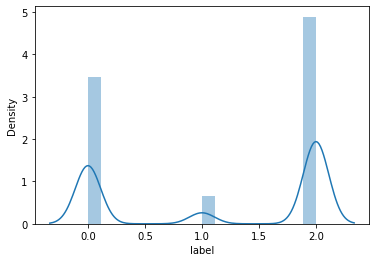

In [ ]:
label_dic = {"functional" : 2, "functional needs repair" : 1, "non functional" : 0}
train_df['label'] = train_df['status_group'].map(label_dic)
sns.distplot(train_df['label'], kde = True)

In [ ]:
major_cls = train_df['status_group'].mode()[0]
print("The most frequent label is", major_cls)

The most frequent label is functional


In [ ]:
y_prilem_pred = np.full(shape=train_df["status_group"].shape, fill_value=major_cls)
accuracy_score(train_df["status_group"],y_prilem_pred)

0.5430751964085297

It means that we can make a preliminary estimate of 54.31% chance of a random pump from this database to be functional. This number will be a baseline for the future model predictions.

In [ ]:
#select numeriacl columns
num_vars = [col for col in train_df.columns if train_df[col].dtype in ['int64','float64']]
print(num_vars)

['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'label']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text major ticklabel objects>)

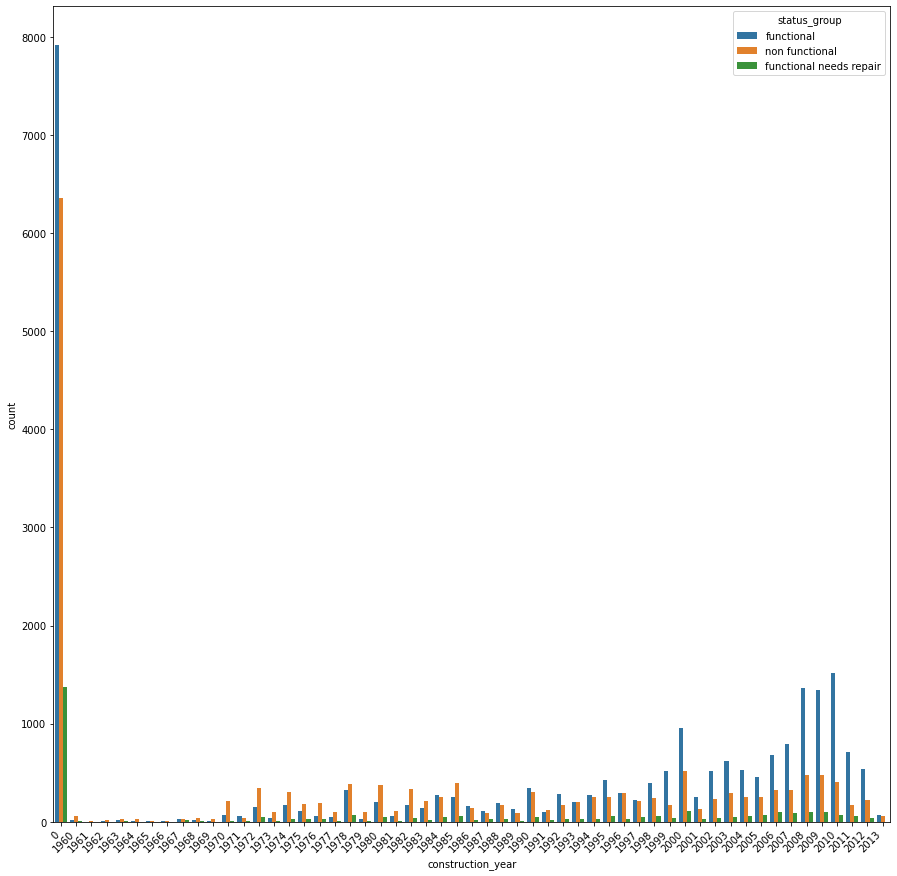

In [ ]:
# Plotting construction_year vs status_group 
fig_dims = (15,15)
fig, ax = plt.subplots(figsize=fig_dims)


sns.countplot(x=train_df["construction_year"], hue=train_df["status_group"])




plt.xticks(rotation=45, horizontalalignment='right')

We can see that most pumps that were built between 1970 to 1985 are non functional, whereas the more recent pumps tend to be functional. It means that the "construction_year" feature could be very useful in our prediction model. The number of pumps that needs repair seems not very high and quite stable over the years. The rows with 0 construction year need to be checked.

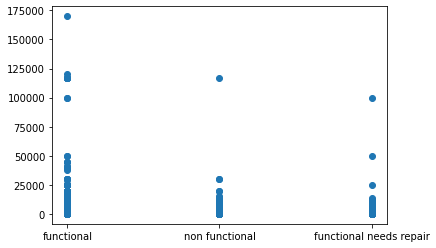

In [ ]:
#Scatter plot of amount_tsh vs status_group
plt.scatter(y=train_df["amount_tsh"], x=train_df["status_group"])

If the "amount_tsh" > 200000 then most likely the pump is functional.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

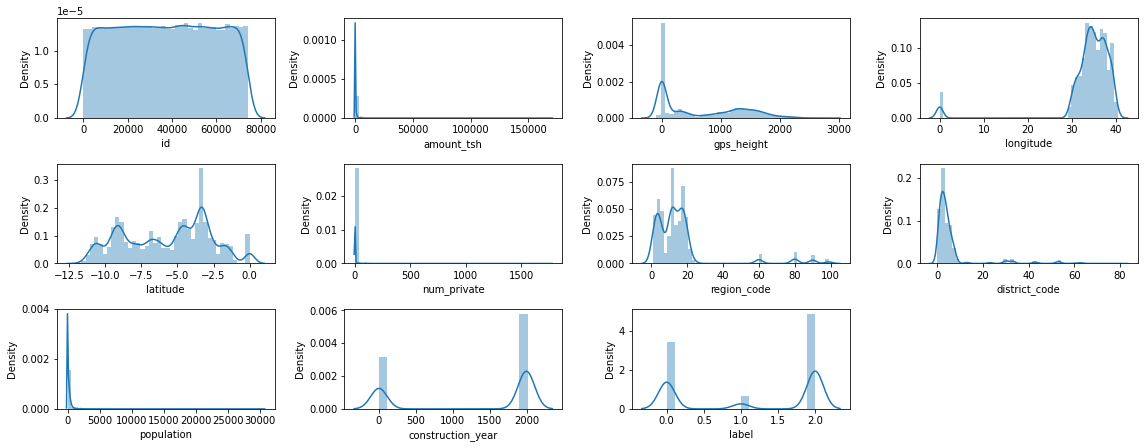

In [ ]:
#Finding the numerical variables distributions
fig = plt.figure(figsize=(16,18))
sns.distributions._has_statsmodels=False
for i in range(len(num_vars)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(train_df[num_vars].iloc[:,i].dropna())
    plt.xlabel(num_vars[i])

plt.tight_layout()
plt.show()

Uni-modal, skewed distributions could potentially be log transformed:

GPS_hight,  
Longtitude,              
Region_code,  
District_code,


Finding outliers

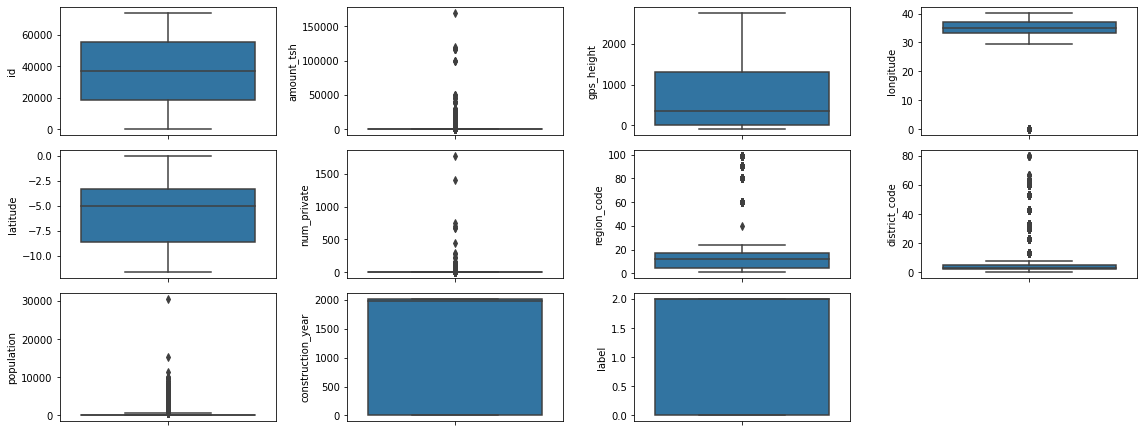

In [ ]:
#Univariate analysis-Box plots for numerical variables
fig = plt.figure(figsize=(16, 18))

for i in range(len(num_vars)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=train_df[num_vars].iloc[:,i])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

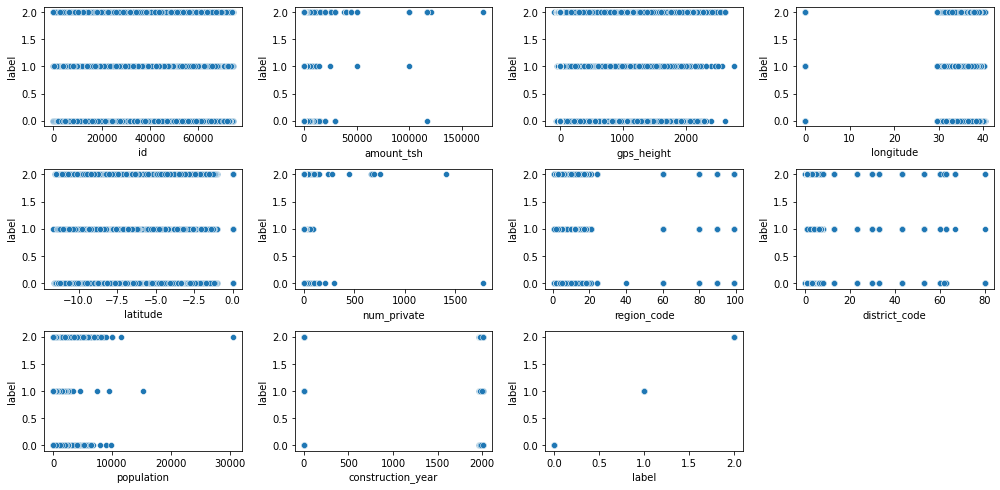

In [ ]:
#Bivariate analysis-Scatter plots target vs numerical variables
f = plt.figure(figsize=(14,20))

for i in range(len(num_vars)):
    f.add_subplot(9, 4, i+1)
    sns.scatterplot(train_df[num_vars].iloc[:,i], train_df["label"])
    
plt.tight_layout()
plt.show()

Finding correlation among variables

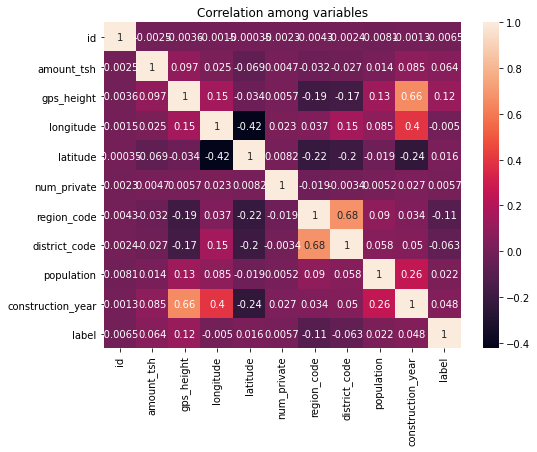

In [ ]:
correlation = train_df.corr()

f, ax = plt.subplots(figsize=(8,6))
plt.title('Correlation among variables', size=12)
sns.heatmap(correlation,xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

The correlation between "district_code" and "region_code" is quite high. Consider removing one of them.

The correlation between "construction_year" and "gps_height" is also high, but these 2 variables don't have any obvious connection, so explore this correlation further to take a decision.

With reference to the target Label, the top correlated attributes are:

In [ ]:
correlation['label'].sort_values(ascending=False)

label                1.000000
gps_height           0.118613
amount_tsh           0.063735
construction_year    0.048077
population           0.022086
latitude             0.015839
num_private          0.005713
longitude           -0.004987
id                  -0.006501
district_code       -0.063177
region_code         -0.105216
Name: label, dtype: float64

The negative correlation to the target variable of the "region_code" is higher than that of the "district_code". Keep the variable with higher correlation to the target.

Linear correlation to the target is quite low for all variables but it might mean that there exists a non-linear correlation instead.

 Missing/null values in numerical columns

In [ ]:
train_df[num_vars].isnull().sum().sort_values(ascending=False)


label                0
construction_year    0
population           0
district_code        0
region_code          0
num_private          0
latitude             0
longitude            0
gps_height           0
amount_tsh           0
id                   0
dtype: int64

In [ ]:
len(train_df.population[train_df.population == 0])

16150

Categorical columns:-

In [ ]:
cat_vars = train_df.select_dtypes(include='object').columns
print(cat_vars)

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


Missing/null values in categorical columns

In [ ]:
train_df[cat_vars].isnull().sum().sort_values(ascending=False)


scheme_name              21110
scheme_management         2832
installer                 2807
funder                    2793
public_meeting            2491
permit                    2336
subvillage                 287
status_group                 0
extraction_type              0
wpt_name                     0
basin                        0
region                       0
lga                          0
ward                         0
recorded_by                  0
extraction_type_group        0
waterpoint_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
date_recorded                0
dtype: int64

2) Variable transformation, feature engineering, feature selection or elimination.

In [ ]:
train_df.nunique(axis=0)

id                       44550
amount_tsh                  85
date_recorded              346
funder                    1651
gps_height                2396
installer                 1854
longitude                43155
latitude                 43155
wpt_name                 28991
num_private                 59
basin                        9
subvillage               16617
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2080
population                 956
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2506
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

Dropping similar features:-           
The following groups of features

(extraction_type, extraction_type_group, extraction_type_class),
(payment, payment_type),            
(water_quality, quality_group),         
(source, source_class),     
(subvillage, region, region_code, district_code, lga, ward),         
(waterpoint_type, waterpoint_type_group)       
(scheme_name, scheme_management)    

contain very similar information, so the correlation between them is high. This way we are risking overfitting the training data by including all the features in our analysis.

And num_private is ~99% zeros and has no description



In [ ]:
train_df.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,label
0,7411,7.0,2013-03-20,Germany Republi,1203,CES,37.228664,-3.256505,Kwa Abdalla,0,Pangani,Mafurini,Kilimanjaro,3,5,Hai,Machame Kaskazini,90,True,GeoData Consultants Ltd,Water Board,Machame water supply,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2


In [ ]:
train_df = train_df.drop(['id','installer','wpt_name','num_private','subvillage',
               'region','district_code','lga','ward','scheme_name',
               'extraction_type_group','extraction_type_class','management_group','payment','water_quality',
               'quantity','source_type','waterpoint_type_group','status_group'], axis =1)

In [ ]:
train_df.head()

,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,basin,region_code,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,management,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,label
0,7.0,2013-03-20,Germany Republi,1203,37.228664,-3.256505,Pangani,3,90,True,GeoData Consultants Ltd,Water Board,True,2008,gravity,water board,per bucket,good,enough,spring,groundwater,communal standpipe,2
1,0.0,2011-02-21,Cdtf,1409,34.615481,-9.972601,Lake Nyasa,11,70,False,GeoData Consultants Ltd,Private operator,False,1984,gravity,private operator,never pay,good,enough,spring,groundwater,communal standpipe,2
2,0.0,2013-01-04,Government Of Tanzania,1572,36.658778,-3.321529,Pangani,2,150,True,GeoData Consultants Ltd,VWC,True,2002,gravity,vwc,never pay,good,insufficient,spring,groundwater,communal standpipe,0
3,0.0,2011-04-03,District Council,0,33.628025,-8.860795,Rufiji,12,0,True,GeoData Consultants Ltd,VWC,True,0,gravity,wug,annually,good,insufficient,river,surface,communal standpipe,2
4,300.0,2013-03-08,District Council,1283,37.655509,-3.669777,Pangani,3,34,True,GeoData Consultants Ltd,VWC,False,2007,gravity,vwc,monthly,good,insufficient,spring,groundwater,communal standpipe,2


In [ ]:
train_df.shape

(44550, 23)

In [ ]:
test_df = test_df.drop(['id','installer','wpt_name','num_private','subvillage',
               'region','district_code','lga','ward','scheme_name',
               'extraction_type_group','extraction_type_class','management_group','payment','water_quality',
               'quantity','source_type','waterpoint_type_group'], axis =1)

In [ ]:
test_df.head()

,Unnamed: 0,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,basin,region_code,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,management,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type
0,0,0.0,2011-02-25,Kuamu,1676,35.247289,-8.113243,Rufiji,11,769,True,GeoData Consultants Ltd,VWC,True,2004,gravity,vwc,never pay,good,dry,spring,groundwater,communal standpipe
1,1,0.0,2011-04-17,Kirde,0,36.163435,-5.218454,Wami / Ruvu,1,0,True,GeoData Consultants Ltd,VWC,False,0,mono,vwc,never pay,good,enough,machine dbh,groundwater,communal standpipe
2,2,0.0,2011-03-27,Water,0,36.363337,-7.297600,Rufiji,1,0,True,GeoData Consultants Ltd,VWC,True,0,nira/tanira,vwc,never pay,good,enough,shallow well,groundwater,hand pump
3,3,0.0,2011-07-14,Ka,0,31.496315,-2.167140,Lake Victoria,18,0,True,GeoData Consultants Ltd,VWC,True,0,other,vwc,never pay,good,enough,shallow well,groundwater,hand pump
4,4,0.0,2011-07-31,World Vision,0,31.843905,-1.244841,Lake Victoria,18,0,True,GeoData Consultants Ltd,VWC,True,0,gravity,vwc,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe


In [ ]:
test_df.shape

(14850, 23)

Dealing with missing values

In [ ]:
train_df.isnull().sum()

amount_tsh              0
date_recorded           0
funder               2793
gps_height              0
longitude               0
latitude                0
basin                   0
region_code             0
population              0
public_meeting       2491
recorded_by             0
scheme_management    2832
permit               2336
construction_year       0
extraction_type         0
management              0
payment_type            0
quality_group           0
quantity_group          0
source                  0
source_class            0
waterpoint_type         0
label                   0
dtype: int64

In [ ]:
test_df.isnull().sum()

Unnamed: 0              0
amount_tsh              0
date_recorded           0
funder                842
gps_height              0
longitude               0
latitude                0
basin                   0
region_code             0
population              0
public_meeting        843
recorded_by             0
scheme_management    1045
permit                720
construction_year       0
extraction_type         0
management              0
payment_type            0
quality_group           0
quantity_group          0
source                  0
source_class            0
waterpoint_type         0
dtype: int64

In [ ]:
# Null scheme_management, funder, public_meeting and permit values replace with "unknown" text
train_df["scheme_management"].fillna("unknown", inplace = True)
train_df["public_meeting"].fillna("unknown", inplace = True)
train_df["permit"].fillna("unknown", inplace = True)
train_df["funder"].fillna("unknown", inplace = True)

test_df["scheme_management"].fillna("unknown", inplace = True)
test_df["public_meeting"].fillna("unknown", inplace = True)
test_df["permit"].fillna("unknown", inplace = True)
test_df["funder"].fillna("unknown", inplace = True)


In [ ]:
train_df.isnull().sum().sort_values(ascending = False)

label                0
recorded_by          0
date_recorded        0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
population           0
public_meeting       0
scheme_management    0
waterpoint_type      0
permit               0
construction_year    0
extraction_type      0
management           0
payment_type         0
quality_group        0
quantity_group       0
source               0
source_class         0
amount_tsh           0
dtype: int64

In [ ]:
test_df.isnull().sum().sort_values(ascending = False)

waterpoint_type      0
public_meeting       0
amount_tsh           0
date_recorded        0
funder               0
gps_height           0
longitude            0
latitude             0
basin                0
region_code          0
population           0
recorded_by          0
source_class         0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment_type         0
quality_group        0
quantity_group       0
source               0
Unnamed: 0           0
dtype: int64

Reducing cardinality

selecting features

In [ ]:
# Get number of unique entries in each column with categorical data

cat_vars = train_df.select_dtypes(include='object').columns
object_nunique = list(map(lambda col: train_df[col].nunique(), cat_vars))
d = dict(zip(cat_vars, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('recorded_by', 1),
 ('public_meeting', 3),
 ('permit', 3),
 ('source_class', 3),
 ('quantity_group', 5),
 ('quality_group', 6),
 ('payment_type', 7),
 ('waterpoint_type', 7),
 ('basin', 9),
 ('source', 10),
 ('management', 12),
 ('scheme_management', 13),
 ('extraction_type', 18),
 ('date_recorded', 346),
 ('funder', 1652)]

Based on the above analysis:

The "recorded_by" feature can be dropped as there is only 1 unique value, it doesn't help in predicting.

The columns in which values can be ordered we can perform an Ordinal encoding:

quality_group   
quantity_group   
payment_type

The cardinality of the following 2 features should be reduced to 10 and then one-hot encode them or try Binary encoding:

scheme_managenemt   
extraction_type   

The cardinality of "funder" is too high, will drop at the first model run, later could try Frequency encoding,Binary encoding if reduce cardinality to at least 100.

The rest can be one-hot encoded as the cardinality is lower than 10:

public_meeting # later -> Binary?    
permit # later-> Binary?   
source_class   
management_group    
waterpoint_type_group    
source_type    
basin

In [ ]:
train_df = train_df.drop('recorded_by', axis = 1)


In [ ]:
test_df = test_df.drop('recorded_by', axis = 1)

Ordinal encoding of categerical data:-

Quality_group

In [ ]:
train_df.quality_group.value_counts()

good        38093
salty        3932
unknown      1397
milky         606
colored       364
fluoride      158
Name: quality_group, dtype: int64

In [ ]:
order_dict_quality = {"good":3,"salty":2,"milky":2,"colored":2,"fluoride":2,"unknown":1}
train_df["quality_group_code"] = [order_dict_quality[item] for item in train_df.quality_group]
del train_df["quality_group"]

test_df["quality_group_code"] = [order_dict_quality[item] for item in test_df.quality_group]
del test_df["quality_group"]

Quantity_group

In [ ]:
train_df.quantity_group.value_counts()

enough          24821
insufficient    11367
dry              4725
seasonal         3049
unknown           588
Name: quantity_group, dtype: int64

In [ ]:
order_dict_quantity = {"enough":3,"insufficient":2,"dry":2,"seasonal":2,"unknown":1}
train_df["quantity_group_code"] = [order_dict_quantity[item] for item in train_df.quantity_group] 
del train_df["quantity_group"]

test_df["quantity_group_code"] = [order_dict_quantity[item] for item in test_df.quantity_group] 
del test_df["quantity_group"]


Payment_type

In [ ]:
train_df.payment_type.value_counts()

never pay     19002
per bucket     6808
monthly        6182
unknown        6104
on failure     2941
annually       2717
other           796
Name: payment_type, dtype: int64

In [ ]:
order_dict_payment = {"monthly":4,"annually":4,"on failure":3,"per bucket":3,"never pay":2,"unknown":1,"other":1}
train_df["payment_code"] = [order_dict_payment[item] for item in train_df.payment_type] 
del train_df["payment_type"]

test_df["payment_code"] = [order_dict_payment[item] for item in test_df.payment_type] 
del test_df["payment_type"]

Public_meeting

In [ ]:
train_df.public_meeting.value_counts()

True       38212
False       3847
unknown     2491
Name: public_meeting, dtype: int64

In [ ]:
order_dict_pub_meet = {True:2,False:1,"unknown":0}
train_df["public_meeting_code"] = [order_dict_pub_meet[item] for item in train_df.public_meeting] 
del train_df["public_meeting"]

test_df["public_meeting_code"] = [order_dict_pub_meet[item] for item in test_df.public_meeting] 
del test_df["public_meeting"]


Permit

In [ ]:
train_df.permit.value_counts()

True       29057
False      13157
unknown     2336
Name: permit, dtype: int64

In [ ]:
order_dict_permit = {True:2,False:1,"unknown":0}
train_df["permit_code"] = [order_dict_pub_meet[item] for item in train_df.permit] 
del train_df["permit"]

test_df["permit_code"] = [order_dict_pub_meet[item] for item in test_df.permit] 
del test_df["permit"]

One hot encoding

Scheme_managment

In [ ]:
train_df.scheme_management.value_counts()

VWC                 27651
WUG                  3906
unknown              2832
Water authority      2361
WUA                  2166
Water Board          2078
Parastatal           1272
Private operator      792
Company               790
Other                 575
SWC                    69
Trust                  57
None                    1
Name: scheme_management, dtype: int64

In [ ]:
def scheme_wrangler(row):
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    elif row['scheme_management']=='Parastatal':
        return 'parastatal'
    elif row['scheme_management']=='Private operator':
        return 'pri_optr'
    elif row['scheme_management']=='SWC':
        return 'swc'
    elif row['scheme_management']=='Company':
        return 'company'
    else:
        return 'other'
train_df['scheme_management'] = train_df.apply(lambda row: scheme_wrangler(row), axis=1)
test_df['scheme_management'] = test_df.apply(lambda row: scheme_wrangler(row), axis=1)

Extraction_type

In [ ]:
train_df.extraction_type.value_counts()

gravity                      20127
nira/tanira                   6130
other                         4768
submersible                   3560
swn 80                        2771
mono                          2164
india mark ii                 1768
afridev                       1339
ksb                           1043
other - rope pump              335
other - swn 81                 177
windmill                        89
india mark iii                  77
cemo                            70
other - play pump               65
walimi                          39
climax                          26
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [ ]:
def extraction_wrangler(row):
    if row['extraction_type']=='gravity':
        return 'gravity'
    elif row['extraction_type']=='nira/tanira':
        return 'nira/tanira'
    elif row['extraction_type']=='submersible':
        return 'submersible'
    elif row['extraction_type']=='swn 80':
        return 'swn_80'
    elif row['extraction_type']=='mono':
        return 'mono'
    elif row['extraction_type']=='india mark ii':
        return 'india_mark_ii'
    elif row['extraction_type']=='afridev':
        return 'afridev'
    elif row['extraction_type']=='ksb':
        return 'ksb'
    elif row['extraction_type']=='windmill':
        return 'windmill'
    else:
        return 'other'
train_df['extraction_type'] = train_df.apply(lambda row: extraction_wrangler(row), axis=1)
test_df['extraction_type'] = test_df.apply(lambda row: extraction_wrangler(row), axis=1)

Funder

In [ ]:
train_df.funder.value_counts()

Government Of Tanzania    6780
unknown                   2793
Danida                    2362
Hesawa                    1639
Rwssp                     1032
                          ... 
Kc                           1
Norad/japan                  1
Meko Balo                    1
Artisan                      1
College                      1
Name: funder, Length: 1652, dtype: int64

In [ ]:
def funder_wrangler(row):  
    '''Keep top 8 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'gov'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank'   
    elif row['funder']=='Kkkt':
        return 'kkkt'   
    elif row['funder']=='World Vision':
        return 'world_vision'  
    elif row['funder']=='Unicef':
        return 'unicef'
    else:
        return 'other'
train_df['funder'] = train_df.apply(lambda row: funder_wrangler(row), axis=1)
test_df['funder'] = test_df.apply(lambda row: funder_wrangler(row), axis=1)

Feature Engineering


Amount_tsh:-  
Based on the plot amount_tsh vs status_group ,if amount_tsh > 200000 are most likely to be functional


In [ ]:
train_df.loc[train_df['amount_tsh'] < 200000, 'amount_tsh'] = 0
train_df.loc[train_df['amount_tsh'] >= 200000, 'amount_tsh'] = 1

test_df.loc[train_df['amount_tsh'] < 200000, 'amount_tsh'] = 0
test_df.loc[train_df['amount_tsh'] >= 200000, 'amount_tsh'] = 1


Linear Discriminant Analysis (LDA):-

latitude    
longitude   
gps_height

In [ ]:
LDA_cols = ["latitude","longitude","gps_height"]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_df_sc = sc.fit_transform(train_df[LDA_cols])
test_df_sc = sc.transform(test_df[LDA_cols])

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)

train_df_lda = lda.fit_transform(train_df_sc, train_df.label.values.ravel())
test_df_lda = lda.transform(test_df_sc)

train_df = pd.concat((pd.DataFrame(train_df_lda), train_df), axis=1)
test_df = pd.concat((pd.DataFrame(test_df_lda), test_df), axis=1)

for i in LDA_cols:
    del train_df[i]
    del test_df[i]

In [ ]:
train_df.rename(columns={0: "LDA_0",1:"LDA_1"},inplace=True)
test_df.rename(columns={0: "LDA_0",1:"LDA_1"},inplace=True)

Construction year:-    
We will turn construction_year into a categorical column with bins containing the following values: '60s', '70s', '80s', '90s, '00s', '10s', 'unknown'.

In [ ]:
def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
train_df['construction_year'] = train_df.apply(lambda row: construction_wrangler(row), axis=1)
test_df['construction_year'] = test_df.apply(lambda row: construction_wrangler(row), axis=1)


 Date_recorded:-    
 We will calculate the number of days past since the date_recorded of a particular pump till the most recent date of the dataset. The idea being that more recently recorded pumps might be more likely to be functional than non-functional.



In [ ]:
train_df.date_recorded = pd.to_datetime(train_df.date_recorded)
test_df.date_recorded = pd.to_datetime(test_df.date_recorded)

train_df.date_recorded.describe()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


count                   44550
unique                    346
top       2011-03-15 00:00:00
freq                      423
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

The most recent data is 2013-12-03. Subtract each date from this point to obtain a 'days_since_recorded' column.

In [ ]:
train_df['days_since_recorded'] = pd.datetime(2013, 12, 3) - pd.to_datetime(train_df.date_recorded)
train_df['days_since_recorded'] = train_df['days_since_recorded'].astype('timedelta64[D]').astype(int)

test_df['days_since_recorded'] = pd.datetime(2013, 12, 3) - pd.to_datetime(test_df.date_recorded)
test_df['days_since_recorded'] = test_df['days_since_recorded'].astype('timedelta64[D]').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [ ]:
train_df['days_since_recorded']

0         258
1        1016
2         333
3         975
4         270
         ... 
44545     314
44546     862
44547     283
44548     252
44549     311
Name: days_since_recorded, Length: 44550, dtype: int64

In [ ]:
train_df = train_df.drop("date_recorded",axis=1)
test_df = test_df.drop("date_recorded",axis=1)

In [ ]:
train_df.head()

,LDA_0,LDA_1,amount_tsh,funder,basin,region_code,population,scheme_management,construction_year,extraction_type,management,source,source_class,waterpoint_type,label,quality_group_code,quantity_group_code,payment_code,public_meeting_code,permit_code,days_since_recorded
0,0.384948,0.854298,0.0,other,Pangani,3,90,wtr_brd,00s,gravity,water board,spring,groundwater,communal standpipe,2,3,3,3,2,2,258
1,0.676260,0.647431,0.0,other,Lake Nyasa,11,70,pri_optr,80s,gravity,private operator,spring,groundwater,communal standpipe,2,3,3,2,1,1,1016
2,0.873908,1.109918,0.0,gov,Pangani,2,150,vwc,00s,gravity,vwc,spring,groundwater,communal standpipe,0,3,2,2,2,2,333
3,-0.835115,-0.672458,0.0,other,Rufiji,12,0,vwc,unknown,gravity,wug,river,surface,communal standpipe,2,3,2,4,2,2,975
4,0.420906,0.966124,0.0,other,Pangani,3,34,vwc,00s,gravity,vwc,spring,groundwater,communal standpipe,2,3,2,4,2,1,270


In [ ]:
train_df.shape

(44550, 21)

In [ ]:
test_df.head()

,LDA_0,LDA_1,Unnamed: 0,amount_tsh,funder,basin,region_code,population,scheme_management,construction_year,extraction_type,management,source,source_class,waterpoint_type,quality_group_code,quantity_group_code,payment_code,public_meeting_code,permit_code,days_since_recorded
0,0.984555,0.975911,0,0.0,other,Rufiji,11,769,vwc,00s,gravity,vwc,spring,groundwater,communal standpipe,3,2,2,2,2,1012
1,-0.977980,-0.337494,1,0.0,other,Wami / Ruvu,1,0,vwc,unknown,mono,vwc,machine dbh,groundwater,communal standpipe,3,3,2,2,1,961
2,-1.066876,-0.343516,2,0.0,other,Rufiji,1,0,vwc,unknown,nira/tanira,vwc,shallow well,groundwater,hand pump,3,3,2,2,2,982
3,-0.394932,-0.820374,3,0.0,other,Lake Victoria,18,0,vwc,unknown,other,vwc,shallow well,groundwater,hand pump,3,3,2,2,2,873
4,-0.400643,-0.768655,4,0.0,world_vision,Lake Victoria,18,0,vwc,unknown,gravity,vwc,rainwater harvesting,surface,communal standpipe,3,2,2,2,2,856


In [ ]:
test_df.columns

Index(['LDA_0', 'LDA_1', 'Unnamed: 0', 'amount_tsh', 'funder', 'basin',
       'region_code', 'population', 'scheme_management', 'construction_year',
       'extraction_type', 'management', 'source', 'source_class',
       'waterpoint_type', 'quality_group_code', 'quantity_group_code',
       'payment_code', 'public_meeting_code', 'permit_code',
       'days_since_recorded'],
      dtype='object')

In [ ]:
test_df = test_df.drop('Unnamed: 0', axis = 1)

In [ ]:
test_df.shape

(14850, 20)

One-hot encoding of categorical features

In [ ]:
cat_vars = train_df.select_dtypes(include='object').columns
print(cat_vars)
len(cat_vars)

Index(['funder', 'basin', 'scheme_management', 'construction_year',
       'extraction_type', 'management', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object')


9

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_df[cat_vars])).astype(np.int64)
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_df[cat_vars])).astype(np.int64)

# One-hot encoding removed index; put it back
OH_cols_train.index = train_df.index
OH_cols_test.index = test_df.index

OH_cols_train.columns = OH_encoder.get_feature_names(cat_vars)
OH_cols_test.columns = OH_encoder.get_feature_names(cat_vars)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_df.drop(cat_vars, axis=1)
num_X_valid = test_df.drop(cat_vars, axis=1)

# Add one-hot encoded columns to numerical features
OH_train_df = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_test_df = pd.concat([num_X_valid, OH_cols_test], axis=1)

In [ ]:
OH_train_df.head()

,LDA_0,LDA_1,amount_tsh,region_code,population,label,quality_group_code,quantity_group_code,payment_code,public_meeting_code,permit_code,days_since_recorded,funder_danida,funder_gov,funder_hesawa,funder_kkkt,funder_other,funder_rwssp,funder_unicef,funder_world_bank,funder_world_vision,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,scheme_management_company,scheme_management_other,scheme_management_parastatal,scheme_management_pri_optr,scheme_management_swc,scheme_management_vwc,scheme_management_wtr_auth,scheme_management_wtr_brd,scheme_management_wua,scheme_management_wug,...,extraction_type_india_mark_ii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_submersible,extraction_type_swn_80,extraction_type_windmill,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0.384948,0.854298,0.0,3,90,2,3,3,3,2,2,258,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
1,0.676260,0.647431,0.0,11,70,2,3,3,2,1,1,1016,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
2,0.873908,1.109918,0.0,2,150,0,3,2,2,2,2,333,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
3,-0.835115,-0.672458,0.0,12,0,2,3,2,4,2,2,975,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
4,0.420906,0.966124,0.0,3,34,2,3,2,4,2,1,270,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0


3) Declaration of ML frameworks (e.g. SVM with Gaussian kernel) to be used with a prior
hypothesis of which method is likely to work better (it does not matter if your initial
hypothesis turns out to be wrong) due to insights from the previous steps. Declare some
resources on the net that you read to find out which ML framework is better suited for
which type of data.

L1-regularization with Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

X, y = OH_train_df[OH_train_df.columns.drop("label")], OH_train_df['label']

# Set the regularization parameter C=1

logistic = LogisticRegression(solver="saga",C=1, penalty="l1", random_state=7).fit(X, y)
model = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([[ 0.3849476 ,  0.85429819,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67625965,  0.64743113, 11.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.87390766,  1.10991784,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.08421526,  0.31386663, 10.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3569731 ,  0.97002338,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.61683564, -0.68267108, 14.        , ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
# Get back the kept features as a DataFrame with dropped columns as all 0s

selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

# Dropped columns have values of all 0s, keep other columns 
selected_columns = selected_features.columns[selected_features.var() != 0]

In [ ]:
len(selected_columns)

79

In [ ]:
selected_columns

Index(['LDA_0', 'LDA_1', 'region_code', 'population', 'quality_group_code',
       'quantity_group_code', 'payment_code', 'public_meeting_code',
       'permit_code', 'days_since_recorded', 'funder_danida', 'funder_gov',
       'funder_hesawa', 'funder_other', 'funder_rwssp', 'funder_unicef',
       'funder_world_bank', 'funder_world_vision', 'basin_Internal',
       'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji',
       'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu',
       'scheme_management_company', 'scheme_management_other',
       'scheme_management_parastatal', 'scheme_management_pri_optr',
       'scheme_management_swc', 'scheme_management_vwc',
       'scheme_management_wtr_auth', 'scheme_management_wtr_brd',
       'scheme_management_wua', 'scheme_management_wug',
       'construction_year_00s', 'construction_year_10s',
       'construction_year_60s', 'construction_year_70s',
       'constru

In [ ]:
train_df_selected_features = OH_train_df[selected_columns].join(y)

In [ ]:
test_df_selected_features = OH_test_df[selected_columns]

In [ ]:
train_df_selected_features.shape

(44550, 80)

In [ ]:
train_df_selected_features.to_csv("train_df_final.csv", index=False)
test_df_selected_features.to_csv("test_df_final.csv", index=False)

4) Diligent hyperparameter tuning for at least three frameworks.

In [ ]:
#Importing required labraries for model selection

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Trees    
from sklearn.tree import DecisionTreeClassifier

#Ensemble
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier

#SVM
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# PCA
from sklearn import decomposition


In [ ]:
train_df_final = pd.read_csv("/content/train_df_final.csv")
X_test_final = pd.read_csv("/content/test_df_final.csv")

In [ ]:
X_test_final.shape

(14850, 79)

In [ ]:
train_df_final.shape

(44550, 80)

Train/Test splitting

In [ ]:
X = train_df_final.drop("label",axis=1)
y = train_df_final["label"]

In [ ]:
# Create training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [ ]:
X.isnull().values.any()

False

Standard Scaling:-   
The idea behind StandardScaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.

In [ ]:
sc = ss()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test_final)

Model selection

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_valid)

acc_decision_tree = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_decision_tree

72.4

In [ ]:
# Random Forest

rfc = RandomForestClassifier(criterion='entropy', n_estimators = 1000,min_samples_split=8,random_state=42,verbose=5)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_valid)

acc_rfc = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_rfc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
buildi

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


78.59

In [ ]:
# XGBoost

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=5)
xgb.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

y_pred = xgb.predict(X_valid)
acc_xgb = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_xgb

68.26

In [ ]:
# Linear SVC

linear_SVC = LinearSVC()
linear_SVC.fit(X_train,y_train)
linear_SVC.predict(X_valid)

acc_linear_SVC = round(accuracy_score(y_valid,y_pred) * 100, 2)
acc_linear_SVC

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


68.26

Compare model results

In [ ]:
models = pd.DataFrame({
    'Model': ['Decision Tree','Random Forest','Linear SVC', 
              "XGBoost"],
    'Score': [acc_decision_tree,acc_rfc, acc_linear_SVC, 
              acc_xgb]})
sorted_by_score = models.sort_values(by='Score', ascending=False)


Text(0, 0.5, 'Model')

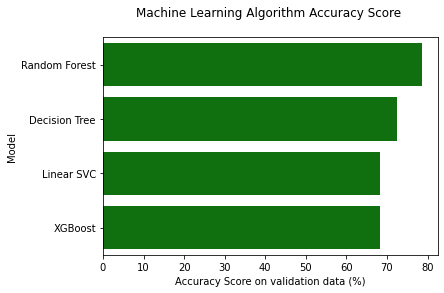

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='Score', y = 'Model', data = sorted_by_score, color = 'g')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score on validation data (%)')
plt.ylabel('Model')

Among the 4 models we have best accuracy for Random Forest

5) Determination of the relative order of importance of variables, and perhaps a second
round of feature selection.

Feature importance with random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini',min_samples_split=8, n_estimators=1000,
                           random_state = 7)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [ ]:
# helper function for creating a feature importance dataframe

def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)

def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [ ]:
base_imp = imp_df(X.columns, rf.feature_importances_)
top_30_imp = base_imp[0:30]
top_30_features = top_30_imp.feature

In [ ]:
pylab.rcParams["figure.figsize"] = (50,50)

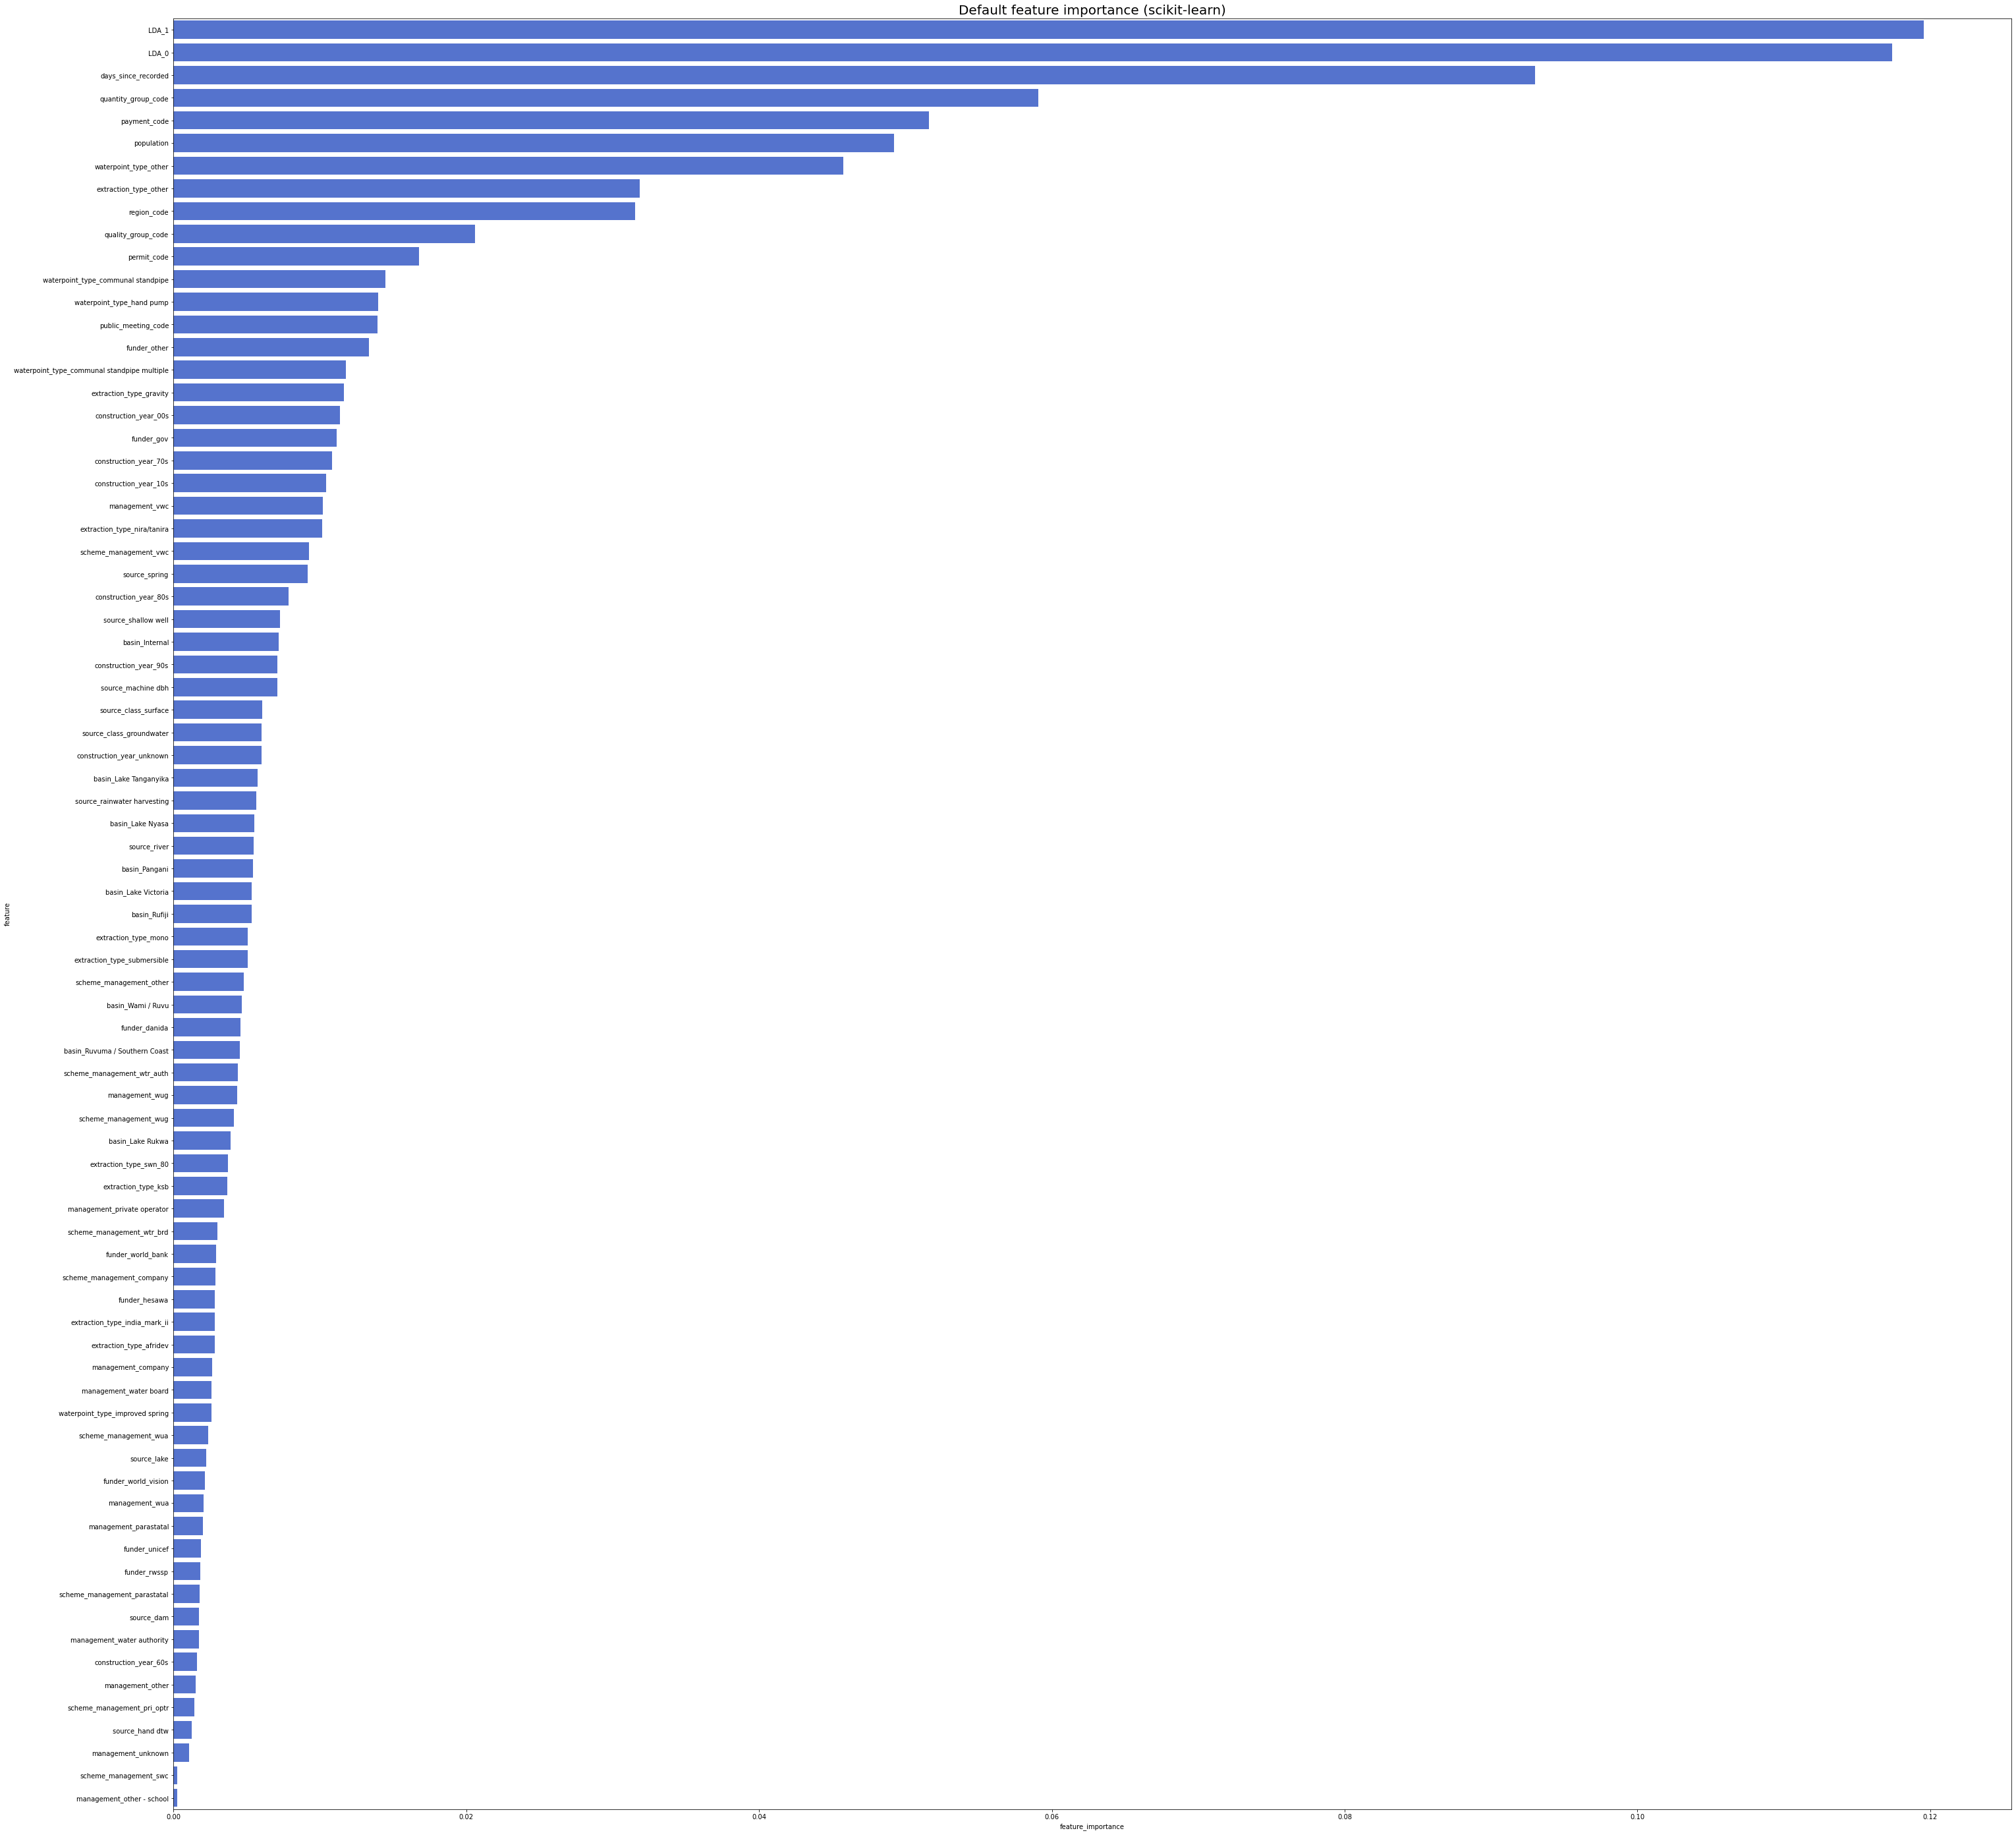

In [ ]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')


In [ ]:
train_df_final_top_imp = OH_train_df[top_30_features].join(y)
test_df_final_top_imp = OH_test_df[top_30_features]

In [ ]:
train_df_final_top_imp.shape

(44550, 31)

7) Submit the final labels (you should not touch the test data before this step) as a CSV file
with a single column and no header.

In [ ]:
submission_df = pd.DataFrame()

In [ ]:
X_test = sc.transform(X_test_final)
submission_df['status_group']=rfc.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.6s finished


In [ ]:
vals_to_replace = {2:'functional', 1:'functional needs repair', 0:'non functional'}

submission_df.status_group = submission_df.status_group.replace(vals_to_replace)

In [ ]:
submission_df.to_csv("submission_TatianaSwrt_rfc_noretrain_80.csv",sep=',', index=False)

In [ ]:
data = pd.read_csv('/content/submission_TatianaSwrt_rfc_noretrain_80.csv')

In [ ]:
data.head()

,status_group
0,functional
1,non functional
2,functional
3,non functional
4,functional


In [ ]:
data.shape

(14850, 1)

8. Make the notebook easy and insightful to read and declare inspiration sources.

References:-

https://www.kaggle.com